<a href="https://colab.research.google.com/github/hongjai-rhee/public/blob/master/%5B6%5D%EA%B3%A0%EA%B0%9D%EB%93%B1%EA%B8%89%EC%98%88%EC%B8%A1_%ED%8C%8C%EC%9D%B4%ED%86%A0%EC%B9%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

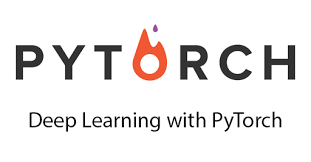

# 고객특성을 보고 등급을 예측하여 보자

In [0]:
## 필요한 라이브러리 불러오기
import pandas as pd; import numpy as np; import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split;  from matplotlib import style

from torch.autograd import Variable
from __future__ import print_function; from torch import nn, optim, cuda, tensor
from torch.utils import data; from torchvision import datasets, transforms
import torch.nn.functional as F ; import time
from sklearn.metrics import accuracy_score, precision_score, recall_score
import torch; from torch.autograd import Variable

# ‘customer1500.csv’ 파일을 구글 드라이브에 마운트 한 다음 데이터 파일을 불러오자




In [45]:
dat = np.array(pd.read_csv('customer1500.csv'))

y=dat[:,0]; x=dat[:,1:65] #  y=3개의 고객상태 label(0/1/2), x=64개의 특성벡터
class_names = ['buy NONE', 'buy SMALL', 'buy BIG']   

## 훈련과 검증셋으로 나누기
x_train=x[0:1000,]; x_test=x[1000:1499,]
y_train=y[0:1000,]; y_test=y[1000:1499,]

# 토치 모맷으로 데이터 바꾸기
x_train = Variable(torch.Tensor(x_train).float())
x_test = Variable(torch.Tensor(x_test).float())
y_train = Variable(torch.Tensor(y_train).long())   ## long =정수
y_test = Variable(torch.Tensor(y_test).long())

print(x_train.shape, y_train.shape)

torch.Size([1000, 64]) torch.Size([1000])


# 모형 설정

In [0]:
class Net(nn.Module):

    def __init__(self):    ## 레이어 구조 설정 (뉴론의 수)
        super(Net, self).__init__()
        #self.l1 = nn.Linear(64, 20)   ## 다양한 층으로 구성가능하다  
        #self.l2 = nn.Linear(20, 10)    
        #self.l3 = nn.Linear(10, 6)    
        #self.l4 = nn.Linear(6, 4)    
        self.l5 = nn.Linear(64, 3)    ## 아웃풋레이어

    def forward(self, x):  ## 연산방법과 활성화함수 설정
        #x = F.relu(self.l1(x))
        #x = F.relu(self.l2(x))
        #x = F.relu(self.l3(x))
        #x = F.relu(self.l4(x))
        return self.l5(x)               ## no softmax here

model = Net()

criterion = nn.CrossEntropyLoss()    ## 손실함수 지정
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)   ## 최적화모듈 지정


# 학습 실행

In [56]:
nb_epochs = 5000   # 학습횟수, 배치=all

for epoch in range(nb_epochs + 1):
    hypothesis = model(x_train)            # f(x) 계산
    loss = criterion(hypothesis, y_train)  # loss 계산
    loss.backward()                        # 백프로파게이션 for gradient
    optimizer.step()                       # 파라미터 업데이트 
    running_loss = loss.item()

    if epoch % 100 == 0:
        print('number of epoch=','[%d] loss: %.3f' %
                  ( epoch + 1,running_loss))
        running_loss = 0.0

## 츨력사항 지정
predict_out = model(x_test)
_, predict_y = torch.max(predict_out, 1)
print('===================>>>>>>')
print('test-set prediction accuracy = ', np.round(100*accuracy_score(y_test.data, predict_y.data),2), "%")

number of epoch= [1] loss: 0.000
number of epoch= [101] loss: 0.000
number of epoch= [201] loss: 0.000
number of epoch= [301] loss: 0.000
number of epoch= [401] loss: 0.000
number of epoch= [501] loss: 0.020
number of epoch= [601] loss: 0.057
number of epoch= [701] loss: 0.057
number of epoch= [801] loss: 0.018
number of epoch= [901] loss: 0.036
number of epoch= [1001] loss: 0.058
number of epoch= [1101] loss: 0.069
number of epoch= [1201] loss: 0.067
number of epoch= [1301] loss: 0.053
number of epoch= [1401] loss: 0.026
number of epoch= [1501] loss: 0.000
number of epoch= [1601] loss: 0.000
number of epoch= [1701] loss: 0.000
number of epoch= [1801] loss: 0.013
number of epoch= [1901] loss: 0.025
number of epoch= [2001] loss: 0.024
number of epoch= [2101] loss: 0.010
number of epoch= [2201] loss: 0.000
number of epoch= [2301] loss: 0.000
number of epoch= [2401] loss: 0.000
number of epoch= [2501] loss: 0.005
number of epoch= [2601] loss: 0.012
number of epoch= [2701] loss: 0.007
numb

# 예측하기

In [63]:
# 예측하기 
i=29
x_new= x_test[i]; 
print('x=', x_new.data)
yhat = F.softmax(model(x_new),0)
print()
print('y=', torch.argmax(yhat))
print('Expected probability=', yhat.data)
#EOF

x= tensor([1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1.,
        1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0.,
        1., 0., 1., 0., 0., 0., 1., 0., 0., 1.])

y= tensor(2)
Expected probability= tensor([0., 0., 1.])
